In [27]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple, Set, Dict
from enum import Enum
import time
import random
from copy import deepcopy

print("Libraries imported successfully!")

Libraries imported successfully!


## Define Constants and Antenna Specifications

We define three antenna types with their properties:
- **Small**: Shortest range, cheapest
- **Medium**: Moderate range and cost
- **Large**: Longest range, most expensive

In [28]:
# Constants
USERS_PER_HOUSE = 100

# Antenna Types
class AntennaType(str, Enum):
    SMALL = "Small"
    MEDIUM = "Medium"
    LARGE = "Large"

# Antenna Specifications
class AntennaSpec:
    def __init__(self, type: AntennaType, radius: int, cost: int):
        self.type = type
        self.radius = radius
        self.cost = cost
    
    def __repr__(self):
        return f"{self.type.value}(radius={self.radius}, cost=${self.cost})"

# Define antenna specifications
ANTENNA_SPECS = {
    AntennaType.SMALL: AntennaSpec(AntennaType.SMALL, radius=2, cost=1000),
    AntennaType.MEDIUM: AntennaSpec(AntennaType.MEDIUM, radius=4, cost=1500),
    AntennaType.LARGE: AntennaSpec(AntennaType.LARGE, radius=6, cost=2000),
}

print("Antenna Specifications:")
for spec in ANTENNA_SPECS.values():
    print(f"  {spec}")

Antenna Specifications:
  Small(radius=2, cost=$1000)
  Medium(radius=4, cost=$1500)
  Large(radius=6, cost=$2000)


## Genetic Algorithm Concepts

**Key Concepts:**
- **Chromosome**: A solution representing antenna placements (list of antennas)
- **Population**: Collection of candidate solutions (chromosomes)
- **Fitness**: Score based on coverage and cost (higher is better)
- **Selection**: Choose best solutions for reproduction (tournament selection)
- **Crossover**: Combine two parent solutions to create offspring
- **Mutation**: Random changes to maintain diversity (add/remove/modify antennas)

**Fitness Function:**
```
fitness = 100 × coverage_ratio - normalized_cost + bonus
```
where:
- `coverage_ratio` = houses_covered / total_houses
- `normalized_cost` = total_cost / max_possible_cost
- `bonus` = 50 if coverage_ratio ≥ 100%

## Implement Genetic Algorithm Class

In [29]:
class GeneticAlgorithm:
    """Genetic algorithm for antenna placement optimization."""
    
    def __init__(
        self,
        width: int,
        height: int,
        antenna_specs: Dict[AntennaType, AntennaSpec],
        houses: List[Tuple[int, int]],
        population_size: int = 30,
        generations: int = 50,
        mutation_rate: float = 0.15,
        crossover_rate: float = 0.7
    ):
        """
        Initialize the genetic algorithm.
        
        Args:
            width: Grid width
            height: Grid height
            antenna_specs: Dictionary of antenna specifications
            houses: List of house coordinates
            population_size: Number of solutions in population
            generations: Number of generations to evolve
            mutation_rate: Probability of mutation
            crossover_rate: Probability of crossover
        """
        self.width = width
        self.height = height
        self.antenna_specs = antenna_specs
        self.houses = set(houses)
        self.population_size = population_size
        self.generations = generations
        self.mutation_rate = mutation_rate
        self.crossover_rate = crossover_rate
        
        print(f"Initialized Genetic Algorithm: {width}x{height} grid, {len(houses)} houses")
        print(f"Population: {population_size}, Generations: {generations}")
        print(f"Mutation Rate: {mutation_rate}, Crossover Rate: {crossover_rate}")
    
    def antenna_covers_house(self, antenna: Dict, houses: set) -> bool:
        """Check if an antenna covers at least one house."""
        for house_x, house_y in houses:
            distance = ((antenna['x'] - house_x) ** 2 + (antenna['y'] - house_y) ** 2) ** 0.5
            if distance <= antenna['radius']:
                return True
        return False
    
    def remove_useless_antennas(self, solution: List[Dict]) -> List[Dict]:
        """Remove antennas that don't cover any house."""
        return [antenna for antenna in solution if self.antenna_covers_house(antenna, self.houses)]
    
    def create_random_solution(self, max_antennas: int = 15) -> List[Dict]:
        """Create a random solution (chromosome)."""
        num_antennas = random.randint(1, max_antennas)
        solution = []
        attempts = 0
        max_attempts = num_antennas * 3  # Allow more attempts to find valid positions
        
        while len(solution) < num_antennas and attempts < max_attempts:
            attempts += 1
            # Random position
            x = random.randint(0, self.width - 1)
            y = random.randint(0, self.height - 1)
            
            # Skip if on a house
            if (x, y) in self.houses:
                continue
            
            # Random antenna type
            antenna_type = random.choice(list(self.antenna_specs.keys()))
            spec = self.antenna_specs[antenna_type]
            
            antenna = {
                "x": x,
                "y": y,
                "type": antenna_type,
                "radius": spec.radius,
                "cost": spec.cost
            }
            
            # Only add if it covers at least one house
            if self.antenna_covers_house(antenna, self.houses):
                solution.append(antenna)
        
        return solution
    
    def calculate_fitness(self, solution: List[Dict]) -> float:
        """
        Calculate fitness of a solution.
        Fitness = coverage_weight * coverage_ratio - cost_weight * normalized_cost
        Higher fitness is better.
        """
        if not solution:
            return -float('inf')
        
        # Calculate coverage
        covered_houses = set()
        for antenna in solution:
            for house_x, house_y in self.houses:
                distance = ((antenna['x'] - house_x) ** 2 + (antenna['y'] - house_y) ** 2) ** 0.5
                if distance <= antenna['radius']:
                    covered_houses.add((house_x, house_y))
        
        coverage_ratio = len(covered_houses) / len(self.houses) if self.houses else 0
        
        # Calculate total cost
        total_cost = sum(ant['cost'] for ant in solution)
        max_possible_cost = len(solution) * max(spec.cost for spec in self.antenna_specs.values())
        normalized_cost = total_cost / max_possible_cost if max_possible_cost > 0 else 0
        
        # Fitness function: prioritize coverage, penalize cost
        coverage_weight = 100  # Very high weight for coverage
        cost_weight = 1        # Lower weight for cost
        
        fitness = coverage_weight * coverage_ratio - cost_weight * normalized_cost
        
        # Bonus for 100% coverage
        if coverage_ratio >= 1.0:
            fitness += 50
        
        return fitness
    
    def initialize_population(self) -> List[List[Dict]]:
        """Create initial population of random solutions."""
        return [self.create_random_solution() for _ in range(self.population_size)]
    
    def selection(self, population: List[List[Dict]], fitnesses: List[float]) -> List[List[Dict]]:
        """Tournament selection: choose best from random subset."""
        selected = []
        tournament_size = 3
        
        for _ in range(len(population)):
            # Random tournament
            tournament_indices = random.sample(range(len(population)), tournament_size)
            tournament_fitnesses = [fitnesses[i] for i in tournament_indices]
            winner_idx = tournament_indices[tournament_fitnesses.index(max(tournament_fitnesses))]
            selected.append(deepcopy(population[winner_idx]))
        
        return selected
    
    def crossover(self, parent1: List[Dict], parent2: List[Dict]) -> Tuple[List[Dict], List[Dict]]:
        """Single-point crossover: combine two parent solutions."""
        if random.random() > self.crossover_rate or not parent1 or not parent2:
            return deepcopy(parent1), deepcopy(parent2)
        
        # Single-point crossover
        point1 = random.randint(0, len(parent1))
        point2 = random.randint(0, len(parent2))
        
        child1 = parent1[:point1] + parent2[point2:]
        child2 = parent2[:point2] + parent1[point1:]
        
        # Remove useless antennas from children
        child1 = self.remove_useless_antennas(child1)
        child2 = self.remove_useless_antennas(child2)
        
        return child1, child2
    
    def mutate(self, solution: List[Dict]) -> List[Dict]:
        """Apply random mutations to solution."""
        if random.random() > self.mutation_rate:
            return solution
        
        mutation_type = random.choice(['add', 'remove', 'modify'])
        
        if mutation_type == 'add':
            # Add new antenna (only if it covers at least one house)
            attempts = 0
            max_attempts = 20
            while attempts < max_attempts:
                attempts += 1
                x = random.randint(0, self.width - 1)
                y = random.randint(0, self.height - 1)
                if (x, y) not in self.houses:
                    antenna_type = random.choice(list(self.antenna_specs.keys()))
                    spec = self.antenna_specs[antenna_type]
                    antenna = {
                        "x": x, "y": y, "type": antenna_type,
                        "radius": spec.radius, "cost": spec.cost
                    }
                    # Only add if it covers at least one house
                    if self.antenna_covers_house(antenna, self.houses):
                        solution.append(antenna)
                        break
        
        elif mutation_type == 'remove' and solution:
            # Remove random antenna
            solution.pop(random.randint(0, len(solution) - 1))
        
        elif mutation_type == 'modify' and solution:
            # Modify random antenna type
            idx = random.randint(0, len(solution) - 1)
            old_antenna = solution[idx]
            
            # Try different antenna types
            for antenna_type in self.antenna_specs.keys():
                spec = self.antenna_specs[antenna_type]
                new_antenna = {
                    "x": old_antenna['x'],
                    "y": old_antenna['y'],
                    "type": antenna_type,
                    "radius": spec.radius,
                    "cost": spec.cost
                }
                # Only modify if new type still covers at least one house
                if self.antenna_covers_house(new_antenna, self.houses):
                    solution[idx] = new_antenna
                    break
        
        return solution
    
    def optimize(self) -> Dict:
        """Run the genetic algorithm."""
        print("\nStarting genetic algorithm optimization...")
        print("Constraint: Every antenna must cover at least one house")
        
        start_time = time.time()
        
        # Initialize population
        population = self.initialize_population()
        best_solution = None
        best_fitness = -float('inf')
        
        for generation in range(self.generations):
            # Evaluate fitness
            fitnesses = [self.calculate_fitness(sol) for sol in population]
            
            # Track best solution
            gen_best_idx = fitnesses.index(max(fitnesses))
            if fitnesses[gen_best_idx] > best_fitness:
                best_fitness = fitnesses[gen_best_idx]
                best_solution = deepcopy(population[gen_best_idx])
            
            # Print progress
            if generation % 10 == 0 or generation == self.generations - 1:
                avg_fitness = sum(fitnesses) / len(fitnesses)
                avg_antennas = sum(len(sol) for sol in population) / len(population)
                print(f"  Generation {generation}: Best Fitness = {best_fitness:.2f}, Avg = {avg_fitness:.2f}, Avg Antennas = {avg_antennas:.1f}")
            
            # Selection
            selected = self.selection(population, fitnesses)
            
            # Crossover and Mutation
            next_generation = []
            for i in range(0, len(selected), 2):
                parent1 = selected[i]
                parent2 = selected[i + 1] if i + 1 < len(selected) else selected[0]
                
                child1, child2 = self.crossover(parent1, parent2)
                child1 = self.mutate(child1)
                child2 = self.mutate(child2)
                
                next_generation.extend([child1, child2])
            
            population = next_generation[:self.population_size]
        
        # Calculate final statistics for best solution
        covered_houses = set()
        for antenna in best_solution:
            for house_x, house_y in self.houses:
                distance = ((antenna['x'] - house_x) ** 2 + (antenna['y'] - house_y) ** 2) ** 0.5
                if distance <= antenna['radius']:
                    covered_houses.add((house_x, house_y))
        
        total_houses = len(self.houses)
        houses_covered = len(covered_houses)
        users_covered = houses_covered * USERS_PER_HOUSE
        total_users = total_houses * USERS_PER_HOUSE
        coverage_percentage = (houses_covered / total_houses * 100) if total_houses > 0 else 0
        total_cost = sum(ant['cost'] for ant in best_solution)
        execution_time_ms = (time.time() - start_time) * 1000
        
        print(f"\n✓ Genetic Algorithm complete!")
        print(f"  Antennas placed: {len(best_solution)}")
        print(f"  Total cost: ${total_cost:,}")
        print(f"  Houses covered: {houses_covered}/{total_houses} ({coverage_percentage:.1f}%)")
        print(f"  Users covered: {users_covered:,}/{total_users:,}")
        print(f"  Execution time: {execution_time_ms:.2f} ms")
        
        # Verify constraint
        useless_count = sum(1 for antenna in best_solution if not self.antenna_covers_house(antenna, self.houses))
        print(f"  Useless antennas (covering 0 houses): {useless_count}")
        
        return {
            "antennas": best_solution,
            "houses_covered": houses_covered,
            "total_houses": total_houses,
            "users_covered": users_covered,
            "total_users": total_users,
            "coverage_percentage": coverage_percentage,
            "total_cost": total_cost,
            "execution_time_ms": execution_time_ms
        }

print("GeneticAlgorithm class defined successfully!")

GeneticAlgorithm class defined successfully!


## Create Sample Grid

In [30]:
# Create a sample grid
np.random.seed(42)
GRID_WIDTH = 20
GRID_HEIGHT = 15

# Generate random house positions (15% of grid cells)
num_houses = int(GRID_WIDTH * GRID_HEIGHT * 0.15)
houses = []
while len(houses) < num_houses:
    x = np.random.randint(0, GRID_WIDTH)
    y = np.random.randint(0, GRID_HEIGHT)
    if (x, y) not in houses:
        houses.append((x, y))

print(f"Grid size: {GRID_WIDTH}x{GRID_HEIGHT}")
print(f"Number of houses: {len(houses)}")
print(f"Total users: {len(houses) * USERS_PER_HOUSE}")

Grid size: 20x15
Number of houses: 45
Total users: 4500


## Run Genetic Algorithm

In [31]:
# Initialize and run the genetic algorithm
genetic_algo = GeneticAlgorithm(
    width=GRID_WIDTH,
    height=GRID_HEIGHT,
    antenna_specs=ANTENNA_SPECS,
    houses=houses,
    population_size=30,
    generations=50,
    mutation_rate=0.15,
    crossover_rate=0.7
)

result = genetic_algo.optimize()

Initialized Genetic Algorithm: 20x15 grid, 45 houses
Population: 30, Generations: 50
Mutation Rate: 0.15, Crossover Rate: 0.7

Starting genetic algorithm optimization...
Constraint: Every antenna must cover at least one house
  Generation 0: Best Fitness = 149.27, Avg = 73.16, Avg Antennas = 9.3
  Generation 10: Best Fitness = 149.35, Avg = 135.72, Avg Antennas = 29.9
  Generation 20: Best Fitness = 149.45, Avg = 140.61, Avg Antennas = 67.7
  Generation 20: Best Fitness = 149.45, Avg = 140.61, Avg Antennas = 67.7
  Generation 30: Best Fitness = 149.48, Avg = 145.48, Avg Antennas = 252.9
  Generation 30: Best Fitness = 149.48, Avg = 145.48, Avg Antennas = 252.9
  Generation 40: Best Fitness = 149.50, Avg = 149.49, Avg Antennas = 1104.0
  Generation 40: Best Fitness = 149.50, Avg = 149.49, Avg Antennas = 1104.0
  Generation 49: Best Fitness = 149.50, Avg = 149.50, Avg Antennas = 9133.4
  Generation 49: Best Fitness = 149.50, Avg = 149.50, Avg Antennas = 9133.4

✓ Genetic Algorithm comple

## Visualize Results

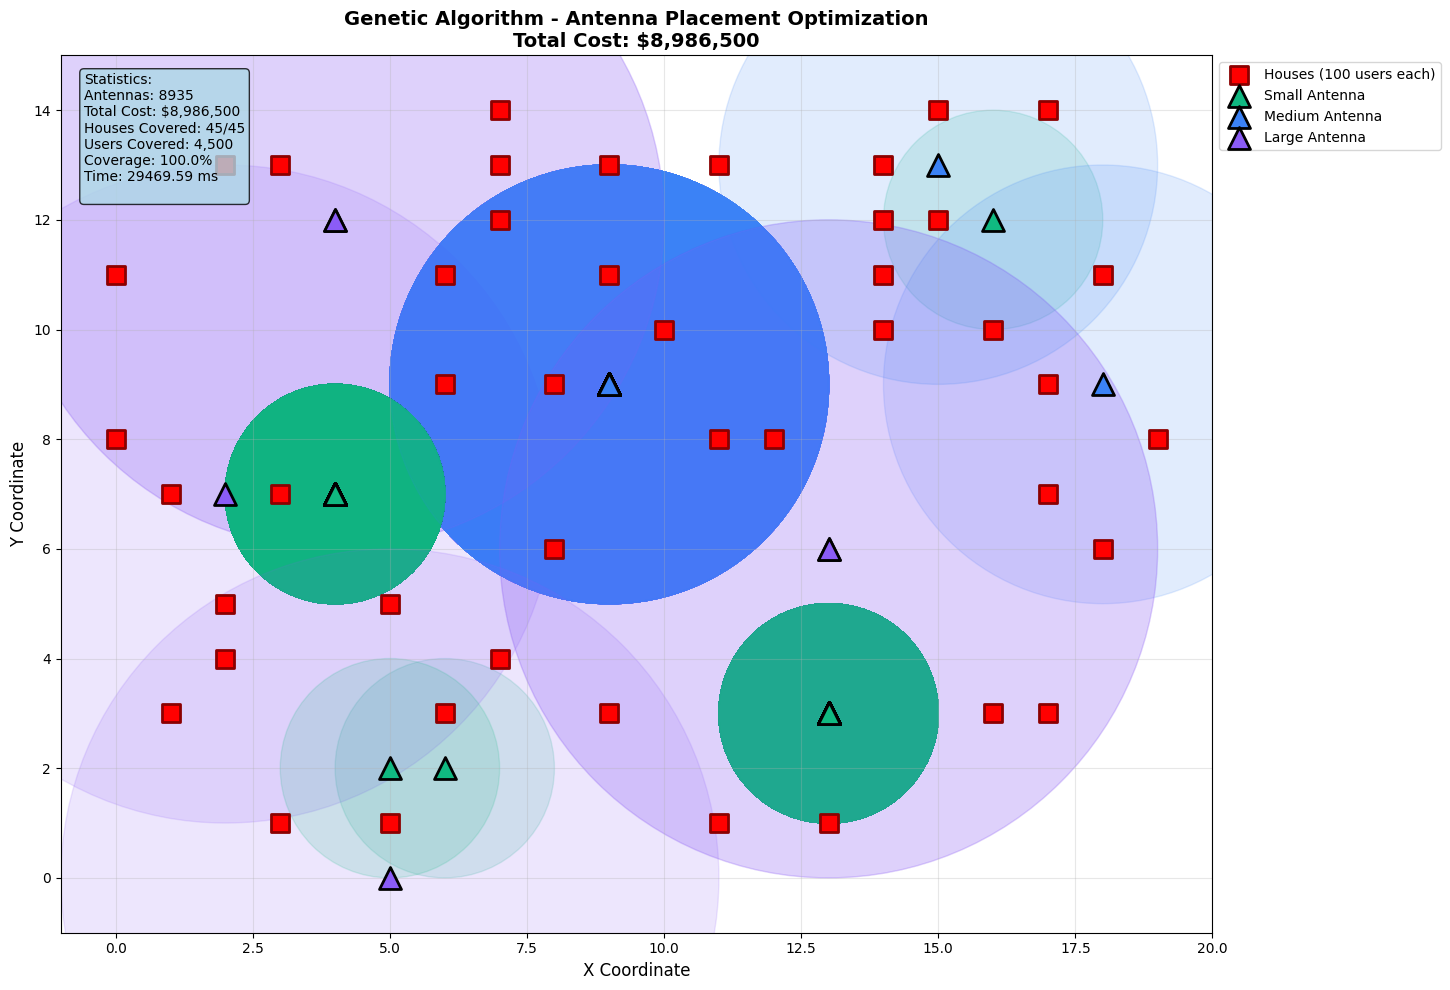


Antenna Breakdown by Type:
  Large: 6 antenna(s) - $12,000
  Medium: 91 antenna(s) - $136,500
  Small: 8838 antenna(s) - $8,838,000


In [32]:
# Visualization
fig, ax = plt.subplots(1, 1, figsize=(14, 10))

# Define colors for each antenna type
antenna_colors = {
    AntennaType.SMALL: '#10B981',   # Green
    AntennaType.MEDIUM: '#3B82F6',  # Blue
    AntennaType.LARGE: '#8B5CF6',   # Purple
}

# Plot coverage circles first (so they're in the background)
for antenna in result['antennas']:
    color = antenna_colors[antenna['type']]
    circle = plt.Circle((antenna['x'], antenna['y']), antenna['radius'], 
                        color=color, alpha=0.15, zorder=1)
    ax.add_patch(circle)

# Plot houses
if houses:
    houses_x, houses_y = zip(*houses)
    ax.scatter(houses_x, houses_y, c='red', s=150, marker='s', 
              label='Houses (100 users each)', zorder=3, edgecolors='darkred', linewidth=2)

# Plot antennas
antenna_types = {}
for antenna in result['antennas']:
    ant_type = antenna['type']
    if ant_type not in antenna_types:
        antenna_types[ant_type] = {'x': [], 'y': []}
    antenna_types[ant_type]['x'].append(antenna['x'])
    antenna_types[ant_type]['y'].append(antenna['y'])

for ant_type, coords in antenna_types.items():
    color = antenna_colors[ant_type]
    ax.scatter(coords['x'], coords['y'], c=color, s=250, marker='^', 
              label=f'{ant_type.value} Antenna', zorder=4, 
              edgecolors='black', linewidth=2)

# Set grid
ax.set_xlim(-1, GRID_WIDTH)
ax.set_ylim(-1, GRID_HEIGHT)
ax.set_aspect('equal')
ax.grid(True, alpha=0.3)
ax.set_xlabel('X Coordinate', fontsize=12)
ax.set_ylabel('Y Coordinate', fontsize=12)
ax.set_title(f'Genetic Algorithm - Antenna Placement Optimization\nTotal Cost: ${result["total_cost"]:,}', 
            fontsize=14, fontweight='bold')

# Add legend
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=10)

# Add statistics text box
stats_text = f"""Statistics:
Antennas: {len(result['antennas'])}
Total Cost: ${result['total_cost']:,}
Houses Covered: {result['houses_covered']}/{result['total_houses']}
Users Covered: {result['users_covered']:,}
Coverage: {result['coverage_percentage']:.1f}%
Time: {result['execution_time_ms']:.2f} ms
"""
props = dict(boxstyle='round', facecolor='lightblue', alpha=0.8)
ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=props)

plt.tight_layout()
plt.show()

# Print antenna breakdown
print("\nAntenna Breakdown by Type:")
antenna_counts = {}
antenna_costs = {}
for antenna in result['antennas']:
    ant_type = antenna['type']
    antenna_counts[ant_type] = antenna_counts.get(ant_type, 0) + 1
    antenna_costs[ant_type] = antenna_costs.get(ant_type, 0) + antenna['cost']

for ant_type in sorted(antenna_counts.keys(), key=lambda x: x.value):
    count = antenna_counts[ant_type]
    cost = antenna_costs[ant_type]
    print(f"  {ant_type.value}: {count} antenna(s) - ${cost:,}")

## Algorithm Summary

**Key Features:**
- **Evolutionary approach**: Explores solution space through generations
- **Population-based**: Maintains multiple candidate solutions
- **Stochastic operators**: Selection, crossover, mutation
- **Fitness-driven**: Balances coverage and cost
- **Complexity**: O(G × P × T × W × H × N) where:
  - G = generations
  - P = population size
  - T = antenna types
  - W × H = grid size
  - N = number of houses

**Advantages:**
- ✓ Explores global solution space
- ✓ Can find near-optimal solutions
- ✓ Handles complex fitness landscapes
- ✓ Parallelizable

**Limitations:**
- ✗ Slower than greedy (seconds vs milliseconds)
- ✗ Non-deterministic (different runs may vary)
- ✗ Requires parameter tuning
- ✗ No guarantee of global optimum

**When to use:**
- When solution quality is critical
- For complex optimization landscapes
- When execution time is acceptable
- For benchmarking against greedy approaches